In [1]:
import time
from dataclasses import dataclass
from dataclasses import field
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import os

print(os.getcwd())
os.chdir('../')
print(os.getcwd())

/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/notebook
/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds


In [3]:
DAY_SECONDS = 60 * 60 * 24


def today() -> pd.Timestamp:
    """
    pd.Timestamp today midnight
    """
    seconds = time.time() - time.timezone
    seconds_round_day = seconds - (seconds % DAY_SECONDS)
    return pd.Timestamp.fromtimestamp(seconds_round_day + time.timezone)

Pick some bonds to use in the current optimization

In [4]:
BOND_UNIVERSE: tuple[str] = (
    "RU000A0GN9A7",
    "RU000A0JWDN6",
    "RU000A0JV4Q1",
#     "RU000A0JVA10",
    "RU000A0JW0S4",
    "RU000A0JUMH3",
    "RU000A0JV4N8",
#     "RU000A0D0G29",
#     "RU000A0JPLH5",
#     "RU000A0JQ8V9",
#     "RU000A0JQAL8",
#     "RU000A0JQAM6",
    "RU000A0JQRD9",
    "RU000A0JWUB5",
#     "RU000A0JWUX9",
    "RU000A0JWV89",
#     "RU000A0JWVL2",
#     "RU000A0JWVT5",
#     "RU000A0JWWM8",
#     "RU000A0JWX04",
#     "RU000A0JWYJ0",
#     "RU000A0JWYQ5",
#     "RU000A0JWZY6",

#     "RU000A101MG4"
)

In [5]:
from functools import cached_property


class BondDataProvider:
    """Data provider for bonds and"""

    def __init__(self):
        """Read all pre-downloaded data."""
        df_price = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_price.csv", parse_dates=["date"])
        df_price["date"] = df_price["date"].dt.date
        df_price = df_price.set_index(["date", "isin"])
        self._price = df_price.sort_index(level="date")

        self._dur = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_duration.csv", parse_dates=["date"])
        self._dur["date"] = self._dur["date"].dt.date
        self._dur = self._dur.set_index(["date", "isin"]).sort_index(level="date")

        self._static = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_static.csv")
        self._rating = pd.read_csv(
            "/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_rating.csv", parse_dates=["update_date"]
        )
        self._rating["update_date"] = self._rating["update_date"].dt.date
        self._rating["isin"] = self._rating["isincode"]

        self._volume = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_volume.csv")
        self._rgbitr = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_rgbitr.csv", parse_dates=["date"])

        self._yield = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_yield.csv", parse_dates=["date"])
        self._yield["date"] = pd.to_datetime(self._yield["date"].dt.date)
        self._yield = self._yield.sort_values("date")

    @property
    def price(self):
        """
        df with bond's historical prices
        columns: 'isin','date','spread','ask','bid','ai','last','mid'
        """
        return self._price

    @property
    def duration(self):
        """
        df with bond's precomputed duration data
        columns: 'id','date','isin','emission_id','emission_emitent_id','trading_ground_id','avar_price',
        'convexity','convexity_offer','dur','dur_to','dur_mod','dur_mod_to'
        """
        return self._dur

    @property
    def static(self):
        """Static bond info including coupon data."""
        return self._static

    @property
    def rating(self):
        """Bond ratings data."""
        return self._rating

    @property
    def volume(self):
        """Traded volume data.
        columns: 'volume' -- traded volume ,'volume_lots' -- number of traded lots
        """
        return self._volume

    @property
    def yield_(self):
        """Estimated bond yields."""
        return self._yield

    @cached_property
    def rgbitr(self):
        """RGBITR benchmark."""
        return self._rgbitr[self._rgbitr["secid"] == "RGBITR"]

    @cached_property
    def rucbitr(self):
        """RUCBITR benchmark.

        Note: halts after 05/31/2023
        """
        return self._rgbitr[self._rgbitr["secid"] == "RUCBITR"]

bond_data = BondDataProvider()

In [6]:
@dataclass
class BondPortfolio:
    """portfolio history and basic statistics."""

    bond_universe: tuple[str] = field(default=tuple)
    cash: float = 1

    def __post_init__(self):
        self.universe_size: int = len(self.bond_universe)

        # current portfolio portions of bonds from the universe
        self._weights: np.array = np.zeros(self.universe_size)

        # current quantities of bonds from the universe
        self._qty: np.array = np.zeros(self.universe_size)

        self._history_weights: dict[pd.Timestamp, np.array] = {}
        self._history_qty: dict[pd.Timestamp, np.array] = {}

        # current date
        self._date: pd.Timestamp = today()

    def update_portfolio(
        self, weights: np.array, qty: np.array, cash: float, date: pd.Timestamp
    ):
        """Should be called when bonds quantity is changed"""
        self._date = date
        self.cash = cash

        self._weights = weights
        self._history_weights[date] = weights

        self._qty = qty
        self._history_qty[date] = qty

    @property
    def weights(self):
        """Weights for the current_date."""
        return self._weights

    def wealth(self, prices: np.array):
        """Total value af assets and money on account."""
        return self.cash + self._qty @ prices

In [7]:
# create portfolio for a simple strategy
port = BondPortfolio(
    bond_universe=BOND_UNIVERSE,
    cash=1,
)

In [8]:
bond_data.price.loc[(slice(None), slice(None)),].index.get_level_values('isin')
rating_reduced = bond_data.rating[
    bond_data.rating["isin"].isin(port.bond_universe)
    & (bond_data.rating.update_date < pd.Timestamp('2023-12-01'))
].sort_values("update_date")

rating_reduced.groupby("isin").num_rating.last()

/Users/svetlanatelnova/opt/anaconda3/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


isin
RU000A0JQRD9    100.0
RU000A0JUMH3     95.0
RU000A0JW0S4     90.0
Name: num_rating, dtype: float64

## Random Weights Strategy

In [9]:
%%time
start_date, end_date = (
    pd.Timestamp("2023-08-01"),
    bond_data.price.index.get_level_values(0).max(),
)
day_ = pd.Timedelta(days=1)

dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)

    if not date in bond_data.price.index.get_level_values('date'):
        continue

    today_bond_data = bond_data.price.loc[(date, port.bond_universe),]
    if len(today_bond_data) < len(port.bond_universe):
        continue

    a = (np.random.uniform(-1, 1, port.universe_size) + 1) / 2

    price_today = bond_data.price.loc[
        pd.IndexSlice[slice(date, date), port.bond_universe], :
    ]
    
    if price_today.empty:
        continue
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid
    new_weights = a / a.sum(axis=0, keepdims=1)

    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today
    print(new_weights)
    print(new_weights - port.weights)
    cash = wealth - qty @ price_today
    port.update_portfolio(new_weights, qty, cash, date)

2023-08-01
wealth = 1.0
[0.15889259 0.16524058 0.12707306 0.18318625 0.04499296 0.08583803
 0.08217887 0.09827752 0.05432015]
[0.15889259 0.16524058 0.12707306 0.18318625 0.04499296 0.08583803
 0.08217887 0.09827752 0.05432015]
2023-08-02
wealth = 0.9998277858323686
[0.1126597  0.14165841 0.17275054 0.06828398 0.01774243 0.13218184
 0.05168614 0.16105848 0.14197849]
[-0.04623289 -0.02358217  0.04567748 -0.11490227 -0.02725053  0.04634381
 -0.03049273  0.06278096  0.08765834]
2023-08-03
wealth = 0.9986632072854384
[0.18853497 0.12869128 0.08587616 0.09858498 0.08069162 0.1197991
 0.18797138 0.02069114 0.08915938]
[ 0.07587527 -0.01296713 -0.08687438  0.030301    0.06294918 -0.01238274
  0.13628525 -0.14036734 -0.05281911]
2023-08-04
wealth = 1.0003415306198535
[0.13827109 0.10503323 0.10584312 0.10543391 0.05962136 0.15254565
 0.01799142 0.14310617 0.17215404]
[-0.05026388 -0.02365805  0.01996697  0.00684894 -0.02107026  0.03274655
 -0.16997996  0.12241503  0.08299466]
2023-08-05
2023-0

2023-09-12
wealth = 0.9950187160693889
[0.02040978 0.01752532 0.02466199 0.02664982 0.07474837 0.28135351
 0.22238016 0.20708697 0.12518407]
[-0.04890991 -0.00335816 -0.10631832 -0.09368915 -0.07217684  0.15861757
  0.12296167  0.05584708 -0.01297394]
2023-09-13
wealth = 0.9881715204254738
[0.05163746 0.22837953 0.03654142 0.17435529 0.13226793 0.15149291
 0.13098964 0.03119744 0.06313838]
[ 0.03122768  0.21085421  0.01187943  0.14770547  0.05751955 -0.1298606
 -0.09139052 -0.17588953 -0.06204569]
2023-09-14
2023-09-15
2023-09-16
2023-09-17
2023-09-18
wealth = 0.990411852806428
[0.02494142 0.12542109 0.18605083 0.18336263 0.1145827  0.05577657
 0.10655052 0.18632951 0.01698473]
[-0.02669603 -0.10295844  0.1495094   0.00900734 -0.01768523 -0.09571634
 -0.02443912  0.15513206 -0.04615365]
2023-09-19
wealth = 0.986304255420733
[0.16190685 0.22010069 0.11352227 0.09895683 0.18215759 0.02464614
 0.0840204  0.02472181 0.08996741]
[ 0.13696543  0.0946796  -0.07252855 -0.0844058   0.06757489 -

### Random Weights Strategy Results

In [10]:
wealth

0.9875110790786231

In [11]:
# df with "dur_mod", "yield", "shape" field for each day and each bond
sharpe_data = (
    bond_data.duration.groupby(["date", "isin"])
    .dur_mod.mean()
    .to_frame()
    .loc[(slice(None), BOND_UNIVERSE), ["dur_mod"]]
    .fillna(float("inf"))
    .join(
        bond_data.yield_.set_index(["date", "isin"]).loc[
            (slice(None), BOND_UNIVERSE), ["yield"]
        ],
    )
)

sharpe_data["sharpe"] = sharpe_data["yield"] / sharpe_data["dur_mod"]
sharpe_data = sharpe_data.sort_index()

In [12]:
sharpe_data_sorted = sharpe_data.loc[date].sort_values(
    "sharpe", ascending=False
)
sharpe_data_sorted["sharpe_squared"] = sharpe_data_sorted["sharpe"] ** 2
sharpe_data_sorted["weight"] = (
    sharpe_data_sorted["sharpe_squared"]
    / sharpe_data_sorted["sharpe_squared"].sum()
)
sharpe_data_sorted
# select max sharp
# weights = (
#     sharpe_data_sorted.loc[(slice(None), universe), :]

,dur_mod,yield,sharpe,sharpe_squared,weight
isin,,,,,
RU000A0JUMH3,0.588109,0.115846,0.196981,0.038802,0.650446
RU000A0JQRD9,1.132534,0.117461,0.103715,0.010757,0.180320
RU000A0JW0S4,1.855754,0.127511,0.068711,0.004721,0.079144
RU000A0JWDN6,2.274082,0.118546,0.052129,0.002717,0.045554
RU000A0JWV89,2.593502,0.095057,0.036652,0.001343,0.022519
RU000A0JWUB5,2.772511,0.070683,0.025494,0.000650,0.010895
RU000A0GN9A7,6.657464,0.115169,0.017299,0.000299,0.005017
RU000A0JV4N8,5.636553,0.081891,0.014529,0.000211,0.003538
RU000A0JV4Q1,6.702876,0.082937,0.012373,0.000153,0.002566


In [13]:
sharpe_data.loc[(date, slice(None)), :].sort_values(
        "sharpe", ascending=False
    )

dur_mod     yield    sharpe
date       isin                                      
2023-09-20 RU000A0JUMH3  0.588109  0.115846  0.196981
           RU000A0JQRD9  1.132534  0.117461  0.103715
           RU000A0JW0S4  1.855754  0.127511  0.068711
           RU000A0JWDN6  2.274082  0.118546  0.052129
           RU000A0JWV89  2.593502  0.095057  0.036652
           RU000A0JWUB5  2.772511  0.070683  0.025494
           RU000A0GN9A7  6.657464  0.115169  0.017299
           RU000A0JV4N8  5.636553  0.081891  0.014529
           RU000A0JV4Q1  6.702876  0.082937  0.012373

In [14]:
port = BondPortfolio(
    cash=1,
    bond_universe=BOND_UNIVERSE,
)

In [15]:
def get_weights(date: datetime.date, universe: tuple[str]):
    """Get target weights based on sharpe ratio."""
    sharpe_data_sorted = sharpe_data.loc[(date, slice(None)), :].sort_values(
        "sharpe", ascending=False
    )
    sharpe_data_sorted["sharpe_squared"] = sharpe_data_sorted["sharpe"] ** 2
    sharpe_data_sorted["weight"] = (
        sharpe_data_sorted["sharpe_squared"]
        / sharpe_data_sorted["sharpe_squared"].sum()
    )

    # select max sharp
    weights = (
        sharpe_data_sorted.loc[(slice(None), universe), :]
        .reset_index()["weight"]
        .fillna(0)
        .values
    )
    assert len(weights) == len(universe), f"{len(weights)},  {len(universe)}"
    return weights

In [16]:
%%time

start_date, end_date = (
    pd.Timestamp("2023-08-01"),
    bond_data.price.index.get_level_values(0).max(),
)
dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)

    if not date in bond_data.price.index.get_level_values('date'):
        continue

    today_bond_data = bond_data.price.loc[(date, port.bond_universe),]
    if len(today_bond_data) < len(port.bond_universe):
        continue

    
    price_today = bond_data.price.loc[slice(date, date), port.bond_universe, :]
    if price_today.empty:
        continue
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid

    new_weights = get_weights(date, BOND_UNIVERSE)  # optimal sharp weights

    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today.values
    cash = wealth - qty @ price_today.values
    print(f"{cash = }")
    port.update_portfolio(new_weights, qty, cash, date)

2023-08-01
wealth = 1.0
cash = 0.0
2023-08-02
wealth = 1.0000344573973512
cash = 0.0
2023-08-03
wealth = 0.9986303937923651
cash = 0.0
2023-08-04
wealth = 0.9990225074061394
cash = -1.1102230246251565e-16
2023-08-05
2023-08-06
2023-08-07
wealth = 0.997690427075624
cash = 1.1102230246251565e-16
2023-08-08
wealth = 0.9966846413990299
cash = -1.1102230246251565e-16
2023-08-09
wealth = 0.9974253241987139
cash = -3.3306690738754696e-16
2023-08-10
2023-08-11
2023-08-12
2023-08-13
2023-08-14
wealth = 0.9965810792064576
cash = 0.0
2023-08-15
wealth = 0.9878933987644237
cash = 1.1102230246251565e-16
2023-08-16
wealth = 0.9945862535275313
cash = 0.0
2023-08-17
wealth = 0.9906304128432077
cash = 1.1102230246251565e-16
2023-08-18
wealth = 0.9937604779554495
cash = 2.220446049250313e-16
2023-08-19
2023-08-20
2023-08-21
wealth = 0.9973086791349274
cash = -2.220446049250313e-16
2023-08-22
wealth = 0.994075223725385
cash = -1.1102230246251565e-16
2023-08-23
wealth = 0.9938929131632144
cash = 1.1102230

### Sharpe Ratio Strategy Results

In [17]:
wealth

0.9830220431908732

## Quadratic optimization

In [18]:
# create portfolio for a quadratic optimization
port = BondPortfolio(
    bond_universe=BOND_UNIVERSE,
    cash=1,
)

In [19]:
%%time

from baseline.quadratic import get_optimal_weights

start_date, end_date = (
    pd.Timestamp("2023-07-01"),
    bond_data.price.index.get_level_values(0).max(),
)
dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)

    if not date in bond_data.price.index.get_level_values('date'):
        continue

    today_bond_data = bond_data.price.loc[(date, slice(None)),]
    if len(today_bond_data) < len(port.bond_universe):
        continue

    price_today = bond_data.price.loc[slice(date, date), port.bond_universe, :]

    if price_today.empty:
        continue
        
    if len(price_today) < len(port.bond_universe):
        continue

    price_today = price_today.loc[(slice(None), port.bond_universe),].mid
    if len(today_bond_data) < len(port.bond_universe):
        continue
    #
    # prepare data
    #
    today_info = (
        price_today.to_frame()
        .join(
            bond_data.duration.loc[
                pd.IndexSlice[slice(date, date), port.bond_universe], "dur_mod"
            ]
            .groupby(["date", "isin"])
            .mean()
            .fillna(float("inf"))
        )
        .join(
            bond_data.yield_.set_index(["date", "isin"]).loc[
                (slice(date, date), port.bond_universe), :
            ]
        )
    )

    rating_reduced = bond_data.rating[
        bond_data.rating["isin"].isin(port.bond_universe)
        & (bond_data.rating.update_date < date)
    ].sort_values("update_date")

    rating_reduced = rating_reduced.groupby("isin").num_rating.last()
    today_info = today_info.join(rating_reduced)
    
    today_info["num_rating"] = today_info["num_rating"].fillna(0)

    #
    # make predictions
    #
    new_weights = get_optimal_weights(
        bond_data=today_info,
        upper_bound=0.5,
        value_date=date,
        maturity_limit=10,
    )  # optimal sharp weights

    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today.values
    cash = wealth - qty @ price_today.values
    print(f"{cash = }")
    port.update_portfolio(new_weights, qty, cash, date)

2023-07-01
2023-07-02
2023-07-03
wealth = 1.0
cash = -8.784084570834239e-13
2023-07-04
2023-07-05
2023-07-06
wealth = 1.0022346890347031
cash = -6.562750343164225e-11
2023-07-07
wealth = 1.0027426023383745
cash = -1.0134115768778429e-12
2023-07-08
2023-07-09
2023-07-10
wealth = 1.0026409970488432
cash = -5.715428130770306e-13
2023-07-11
wealth = 1.001421610004696
cash = -1.396660564978447e-12
2023-07-12
wealth = 1.0026424836529686
cash = -7.460698725481052e-13
2023-07-13
wealth = 1.0015247105385272
cash = -2.0750068330244176e-12
2023-07-14
wealth = 1.0003548238781705
cash = -1.6515677714323829e-12
2023-07-15
2023-07-16
2023-07-17
wealth = 0.9997437335764607
cash = -2.1378454562182014e-12
2023-07-18
wealth = 1.001272393719544
cash = -7.685185821060259e-12
2023-07-19
2023-07-20
wealth = 1.0022899469652535
cash = -2.9547475577373916e-12
2023-07-21
wealth = 1.0006148486280788
cash = -1.965094753586527e-13
2023-07-22
2023-07-23
2023-07-24
wealth = 1.000056413146855
cash = -1.920685832601521

In [20]:
wealth

0.9766973261343168

# Linear programming

In [21]:
from models.linear_programming import linear_minimize

In [37]:
# create portfolio for a linear programming optimization
port = BondPortfolio(
    bond_universe=BOND_UNIVERSE,
    cash=1,
)

In [38]:
%%time

start_date, end_date = (
    pd.Timestamp("2023-07-01"),
    bond_data.price.index.get_level_values(0).max(),
)
dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)

    if not date in bond_data.price.index.get_level_values('date'):
        continue

    today_bond_data = bond_data.price.loc[(date, slice(None)),]
    if len(today_bond_data) < len(port.bond_universe):
        continue
        
    price_today = bond_data.price.loc[slice(date, date), port.bond_universe, :]
    if price_today is None or price_today.empty:
        continue

    if len(price_today) < len(port.bond_universe):
        continue

    price_today = price_today.loc[(slice(None), port.bond_universe),].mid

    #
    # prepare data
    #
    today_info = (
        price_today.to_frame()
        .join(
            bond_data.duration.loc[
                pd.IndexSlice[slice(date, date), port.bond_universe], "dur_mod"
            ]
            .groupby(["date", "isin"])
            .mean()
            .fillna(float("inf"))
        )
        .join(
            bond_data.yield_.set_index(["date", "isin"]).loc[
                (slice(date, date), port.bond_universe), :
            ]
        )
    )

    rating_reduced = bond_data.rating[
        bond_data.rating["isin"].isin(port.bond_universe)
        & (bond_data.rating.update_date < date)
    ].sort_values("update_date")

    rating_reduced = rating_reduced.groupby("isin").num_rating.last()
    today_info = today_info.join(rating_reduced)
    
    today_info["num_rating"] = today_info["num_rating"].fillna(0)
    rating_reduced = today_info["num_rating"]

    new_weights=linear_minimize(today_info, num_rating=rating_reduced, rating_at_least=0)

    if new_weights is None:
        print("No answer for you")

    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today.values
    cash = wealth - qty @ price_today.values
    print(f"{cash = }")
    port.update_portfolio(new_weights, qty, cash, date)

2023-07-01
2023-07-02
2023-07-03
wealth = 1.0
cash = 0.0
2023-07-04
2023-07-05
2023-07-06
wealth = 0.9995569840985569
cash = 0.0
2023-07-07
wealth = 0.9995098547473394
cash = 0.0
2023-07-08
2023-07-09
2023-07-10
wealth = 0.9990951164566267
cash = 0.0
2023-07-11
wealth = 0.9986521005551837
cash = 0.0
2023-07-12
wealth = 0.996955443911359
cash = 0.0
2023-07-13
wealth = 0.9959845792762817
cash = 0.0
2023-07-14
wealth = 0.996314484734803
cash = 0.0
2023-07-15
2023-07-16
2023-07-17
wealth = 0.9951928061758301
cash = 0.0
2023-07-18
wealth = 0.9962862071240727
cash = 0.0
2023-07-19
2023-07-20
wealth = 0.9978226239737583
cash = 0.0
2023-07-21
wealth = 1.001083975077999
cash = 0.0
2023-07-22
2023-07-23
2023-07-24
wealth = 0.997681235920106
cash = 0.0
2023-07-25
wealth = 0.996757500636246
cash = 0.0
2023-07-26
wealth = 0.9949571594197433
cash = 0.0
2023-07-27
wealth = 0.9949006041982825
cash = 0.0
2023-07-28
wealth = 0.9939674430441787
cash = 0.0
2023-07-29
2023-07-30
2023-07-31
wealth = 0.99226

In [24]:
wealth

0.9782168138673402

In [25]:
def get_portfolio_value_history(portfolio: BondPortfolio):
    """
    df with 'qty', 'spread', 'ask', 'bid', 'ai', 'last', 'mid' columns for each bond and trading day of the `portfolio`
    """
    portfolio_df = pd.DataFrame.from_dict(
        portfolio._history_qty, orient="index", columns=portfolio.bond_universe
    )
    portfolio_df.index.name = "date"

    # wide df -> long df
    portfolio_df = pd.melt(
        portfolio_df.reset_index(),
        "date",
        value_vars=portfolio.bond_universe,
        var_name="isin",
        value_name="qty",
    ).set_index(["date", "isin"])

    price_df = bond_data.price.reset_index()
    price_df = price_df.set_index(["date", "isin"])

    portfolio_history = pd.merge(
        portfolio_df,
        price_df,
        how="left",
        left_index=True,
        right_index=True,
    )

    return portfolio_history

#### portfolio PNL

In [26]:
portfolio_summary = get_portfolio_value_history(port)
portfolio_summary["value"] = portfolio_summary["qty"] * portfolio_summary["mid"]
portfolio_summary_grouped = portfolio_summary.groupby("date")

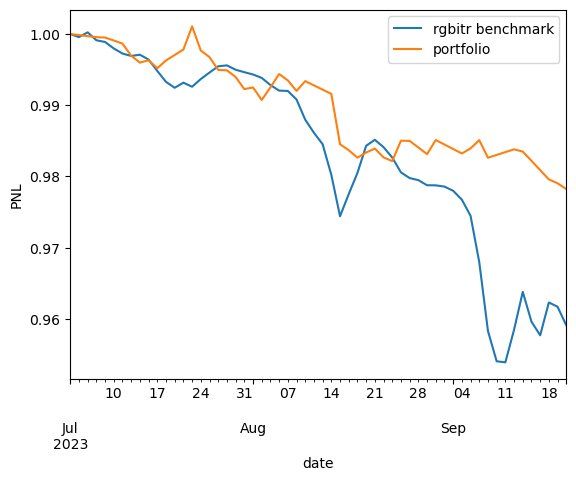

In [27]:
# benchmark rgbitr
rgbitr_slice = bond_data.rgbitr.set_index("date").loc[start_date:end_date]
pnl_benchmark = np.cumprod(rgbitr_slice.close.pct_change().fillna(0) + 1)
pnl_benchmark.index = pd.DatetimeIndex(pnl_benchmark.index)
pnl_benchmark.plot(label="rgbitr benchmark")

# portfolio
pnl_portfolio = portfolio_summary_grouped.value.sum()
pnl_portfolio.index = pd.DatetimeIndex(pnl_portfolio.index)
pnl_portfolio.plot(label="portfolio")

plt.legend()
plt.ylabel("PNL");

### mean and median return

In [28]:
returns = portfolio_summary_grouped.value.sum().pct_change()
f"Mean return = {returns.mean():.3f}, Median return = {returns.median():.3f}"

'Mean return = -0.000, Median return = -0.001'

## Sharpe Ratio

In [29]:
rgbitr_slice = bond_data.rgbitr.set_index("date").loc[start_date:end_date]

returns_benchmark = rgbitr_slice.close.pct_change().iloc[1:]
returns_port = portfolio_summary_grouped.value.sum().pct_change().iloc[1:]

In [30]:
def get_sharp_ratio(returns, returns_market):
    """
    Notes: https://www.investopedia.com/terms/s/sharperatio.asp
    """
    delta = returns.product() - returns_market.product()
    return delta / (returns - returns_market).std()


get_sharp_ratio(returns=returns_benchmark, returns_market=returns_port)

8.350321199928853e-138

### Information Ratio

In [39]:
def get_information_ratio(returns, returns_market):
    """
    Notes: https://www.investopedia.com/terms/i/informationratio.asp
    """
    difference_benchmark_portfolio = returns - returns_market
    tracking_error = difference_benchmark_portfolio.std()
    information_ratio = (returns.mean() - returns_market.mean()) / tracking_error
    return information_ratio

In [40]:
information_ratio = get_information_ratio(
    returns=returns_benchmark, returns_market=returns_port
)
information_ratio

-0.08121380577390663

## Returns

/Users/svetlanatelnova/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/svetlanatelnova/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


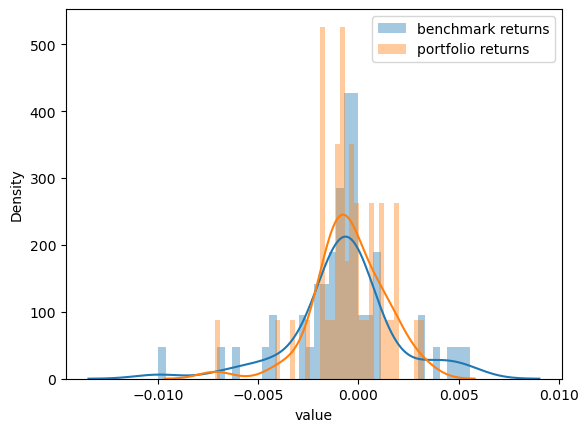

In [41]:
plt.figure()
sns.distplot(returns_benchmark, bins=42, label="benchmark returns")
sns.distplot(returns_port, bins=42, label="portfolio returns")
plt.legend();

# Returns difference

/Users/svetlanatelnova/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


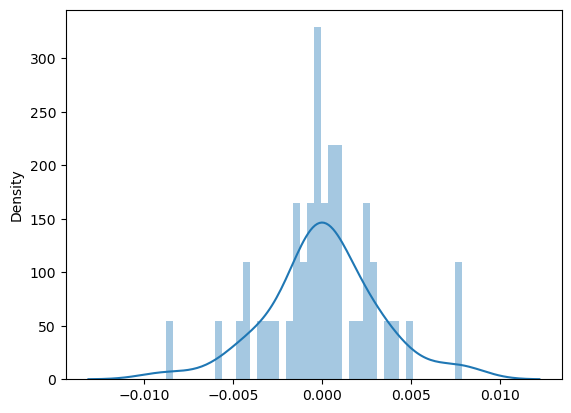

In [42]:
returns_diff = returns_port - returns_benchmark
sns.distplot(returns_diff, bins=42, label="portfolio returns");

In [43]:
from scipy import stats

stats.ttest_1samp(returns_diff, popmean=0)

Ttest_1sampResult(statistic=nan, pvalue=nan)

# Benchmark Timing

One financially based refinement to the regression model is a benchmark timing component. The expanded model is

$$r_{P}(t) = \alpha_{P}+\beta_{P} * r_{B}(t) + \gamma_{P} * max(0, r_{B}(t)) + \epsilon_{P}(t)$$

We include the variable γP to determine whether the manager has any benchmark timing skill. The model includes a "down-market" beta, βP, and an "up-market" beta, βP + γP. If γP is significantly positive, then we say that there is evidence of timing skill; benchmark exposure is significantly different in up and down cases.


In [44]:
import statsmodels.api as sm
import numpy as np

timing_df = returns_benchmark.to_frame().rename(columns={'close':'beta'})
timing_df['gamma'] = timing_df['beta']
timing_df.loc[timing_df['beta'] < 0, 'gamma'] = 0

X = sm.add_constant(timing_df)
benchmark_timing_model = sm.OLS(returns_port,X)
results = benchmark_timing_model.fit()
results.params

ValueError: The indices for endog and exog are not aligned

## Value at Risk

In [45]:
alpha = 0.05
returns_benchmark.quantile(alpha)

-0.004743575670312139

## Skewness of Returns

In [46]:
alpha = 0.05
returns_benchmark.skew()

-0.5220272628536753